In [228]:
import numpy as np
import time
import pandas as pd
from scipy.stats import qmc, norm
import math
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as mp
from scipy.stats import linregress

In [5]:
S0 = 100
K = 100
r = 0.05
sigma = 0.1

mu_jump = -0.005
sigma_jump = 0.1
lambda_jump = 0.75

kappa = np.exp(mu_jump + 0.5 * sigma_jump ** 2) - 1

In [6]:
T = 1
N = 256
dt = T / N
sqrt_dt = np.sqrt(dt)

In [410]:
def style_helper(df, title):
    styled_df = (
        df.style
        .set_caption(title)
        .set_table_styles([
            {
                'selector': 'caption',
                'props': [
                    ('color', '#000'),           # Dark black text
                    ('font-size', '16px'),       # Larger text
                    ('font-weight', 'bold'),     # Bold
                    ('text-align', 'left'),      # Optional alignment
                    ('margin-bottom', '12px')    # Space below the caption
                ]
            }
        ], overwrite=False))  # Important: Don't overwrite table styles
    
    return styled_df

def style_dataframe(data, title):
    
    df = format_data(data)
    df.index = df.index + 1
    
    styled_df = (
        df.style
        .set_caption(title)
        .set_table_styles([
            {
                'selector': 'caption',
                'props': [
                    ('color', '#000'),           # Dark black text
                    ('font-size', '16px'),       # Larger text
                    ('font-weight', 'bold'),     # Bold
                    ('text-align', 'left'),      # Optional alignment
                    ('margin-bottom', '12px')    # Space below the caption
                ]
            }
        ], overwrite=False))  # Important: Don't overwrite table styles
    
    return styled_df


### Control Variates

In [7]:
def geom_control_function(S0, r, sigma, T, N):
    
    n_pil = 1000
    np.random.seed(1)

    res_control_pilot = np.zeros(n_pil)
    res_sample_pilot = np.zeros(n_pil)

    for i in range(n_pil):
        S = np.zeros(N + 1)
        S[0] = S0
        
        U = np.random.normal()
        J = 1
        
        if U < lambda_jump * dt:
            J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)

        for j in range(1, N + 1):
           # S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) * dt + (sigma * math.sqrt(dt) * np.random.normal(0, 1)))
            S[j] = S[j-1] * math.exp((r - (sigma*sigma)/2) * dt + 
                                     sigma * math.sqrt(dt) * np.random.normal(0, 1))

        S = np.delete(S, 0)

        geo_avg = np.exp(np.log(S).mean())
        arith_avg = S.mean()

        res_control_pilot[i] = np.exp(-1 * r * T) * max(geo_avg - K, 0)
        res_sample_pilot[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)  
    
    a = np.log(S0) + (r - (sigma**2 / 2)) * T * (N + 1) / (2*N)
    b = (sigma**2) * (T * (N+1) * (2*N + 1)) / (6 * N*N)

    d1 = (-1 * np.log(K) + a + b) / math.sqrt(b)
    d2 = d1 - math.sqrt(b)

    phi_d1 = norm.cdf(d1)
    phi_d2 = norm.cdf(d2)

    mu_g_analytic = np.exp(-1 * r * T) * (np.exp(a + b/2)*phi_d1 - K * phi_d2)
    beta_estimate = np.cov(res_control_pilot, res_sample_pilot)[0][1] / np.var(res_control_pilot)
    
    return mu_g_analytic, beta_estimate

def european_control_function(S0, r, sigma, T, N):
    
    def black_scholes_call(S0, K, T, r, sigma):
        # Calculate d1 and d2
        d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        # Calculate the call option price using the Black-Scholes formula
        call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

        return call_price
    
    n_pil = 1000
    np.random.seed(1)

    res_control_pilot = np.zeros(n_pil)
    res_sample_pilot = np.zeros(n_pil)

    for i in range(n_pil):
        S = np.zeros(N + 1)
        S[0] = S0

        for j in range(1, N + 1):
            S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) + (sigma * math.sqrt(dt) * np.random.normal(0, 1)))
            #S[j] = S[j-1] * math.exp((r - (sigma*sigma)/2) * dt + 
            #                         sigma * math.sqrt(dt) * np.random.normal(0, 1))

        S = np.delete(S, 0)

        #geo_avg = np.exp(np.log(S).mean())
        euro = S[-1]
        arith_avg = S.mean()

        res_control_pilot[i] = np.exp(-1 * r * T) * max(euro - K, 0)
        res_sample_pilot[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)  
        
        mu_g_analytic = black_scholes_call(S0, K, T, r, sigma)
        beta_estimate = np.cov(res_control_pilot, res_sample_pilot)[0][1] / np.var(res_control_pilot)

        return mu_g_analytic, beta_estimate
    

def control_variates(n):
    
    mu_g_analytic, beta_estimate = geom_control_function(S0, r, sigma, T, N)
    
    result = np.zeros(n)
    result_control = np.zeros(n)
    stocks = np.zeros(n)
    
    for i in range(n):
        S = np.zeros(N + 1)
        S[0] = S0
        
        U = np.random.normal()
        J = 1
        
        if U < lambda_jump * dt:
            J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)

        for j in range(1, N + 1):
            #S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) * dt + (sigma * math.sqrt(dt) * np.random.normal(0, 1)) + (J-1))
            S[j] = S[j-1] * math.exp((r - (sigma*sigma)/2) * dt + 
                                     sigma * math.sqrt(dt) * np.random.normal(0, 1))
            
        S = np.delete(S, 0)

        geo_avg = np.exp(np.log(S).mean())
        arith_avg = S.mean()

        control = np.exp(-1 * r * T) * max(geo_avg - K, 0)
        result[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)
        result_control[i] = result[i] + beta_estimate * (mu_g_analytic - control)
        stocks[i] = S[-1]
        
    return result_control

In [8]:
def payoff_european(S, K, call = True):
    if call:
        return np.maximum(S[-1] - K, 0)
    else:
        return np.maximum(K - S[-1], 0)

def payoff_asian(S, K, likelihoods = None, call = True):
    if call:
        return np.maximum(S.mean(axis = 0) - K, 0)
    else:
        return np.maximum(K - S.mean(axis = 0), 0)
    
def payoff_asian_importance(S, likelihood_ratio = 0.5, call=True):
    raw_payoff = np.maximum(S.mean(axis=0) - K, 0) if call else np.maximum(K - S.mean(axis=0), 0)
    return raw_payoff * likelihood_ratio

In [9]:
def control_variate_asian_asset(S_i, n):
    Z = np.random.normal(size=n)
    S_new = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    return S_new

def payoff_asian_cv(S):
    """
    Returns control variate adjusted payoff.
    S: shape (N, M) array of asset prices
    """
    N, M = S.shape
    avg_price = S.mean(axis=1)
    V = np.exp(-r * T) * np.maximum(avg_price - K, 0)

    S_sum = S.sum(axis=1)
    S_star = np.mean(S_sum)

    cov = np.cov(V, S_sum, bias=True)[0, 1]
    var = np.var(S_sum)
    alpha = cov / var if var > 0 else 0.0

    V_cv = V - alpha * (S_sum - S_star)
    return V_cv


In [10]:
def quasi_brownian_asset(S_i, n):
    Z = quasi_random_normal_samples(n)
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def brownian_asset(S_i, n):
    Z = np.random.normal(loc=0, scale = 1, size = n)    
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def antithetic_brownian_asset(S_i, n):
    Z1 = np.random.normal(size = (int) (n/2))
    Z2 = -Z1
    
    Z = np.empty((Z1.size + Z2.size,), dtype=Z1.dtype)
    Z[0::2] = Z1
    Z[1::2] = Z2
    
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def brownian_asset_importance_sampling(S_i, n, mu_shift=0.2):
    Z = np.random.normal(loc=mu_shift, size=n)
    S_path = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    
    # Likelihood ratio for each Z sample
    likelihood_ratio = np.exp(-mu_shift * Z + 0.5 * mu_shift**2)
    
    return S_path, likelihood_ratio

In [212]:
def mc_asian_importance_sampling(S0, K, r, sigma, dt, mu_shift=0.1, n_sim = 1, n_steps = 1, quasi = False):
    payoffs = []
    
    if quasi:
        Z_quasi = mu_shift + quasi_Sobol(n_sim, n_steps)
    
    for i in range(n_sim):
        if quasi:
            Z = Z_quasi[i]
        else:
            Z = np.random.normal(loc=mu_shift, scale=1.0, size=n_steps)
            
        S_path = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z))
        S_path = np.insert(S_path, 0, S0)
        avg_price = np.mean(S_path)
        payoff = max(avg_price - K, 0)

        # Likelihood ratio (change of measure)
        likelihood = np.exp(-mu_shift * np.sum(Z) + 0.5 * mu_shift**2 * n_steps)
        weighted_payoff = np.exp(-r * T) * payoff * likelihood
        payoffs.append(weighted_payoff)
        
    return cumulative_mean_std(payoffs)

In [12]:
def payoff_asian_importance(S, random_sum, mu_shift, n_steps):
    raw_payoff = np.maximum(S.mean(axis=0) - K, 0)
    likelihoods = -mu_shift * random_sum + 0.5 * mu_shift**2 * n_steps
    return raw_payoff * np.exp(likelihoods)

def importance_sampled_normal(size = 0, mu_shift=0.5):
    Z_shifted = np.random.normal(loc=mu_shift, scale=1)
    likelihood_ratio = np.exp(-mu_shift * Z_shifted + 0.5 * mu_shift**2)
    
    return Z_shifted, likelihood_ratio

def GBM_importance(S_i, r, sigma, dt, sqrt_dt, mu_shift=0.5):
    Z, likelihood_ratio = importance_sampled_normal(size=1, mu_shift=mu_shift)
    S_new = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    return S_new, Z

def run_monte_carlo_IS(S0, K, r, sigma, T, N, n, payoff_function, method, mu_shift=0.5):
    S = np.full((n, N), S0)
    likelihoods = np.ones(n)

    for i in range(1, N):
        S[:, i], new_likelihoods = method(S[:, i - 1], n, mu_shift=mu_shift)
        likelihoods *= new_likelihoods  # Multiply likelihoods across time steps

    print(S[:, -1])
        
    payoffs = payoff_function(S, likelihoods)
    return np.exp(-r * T) * payoffs.mean(), payoffs.std() / np.sqrt(n)


### Importance Sampling

In [392]:
def quasi_Sobol(n, dim):
    sampler = qmc.Sobol(d=dim, scramble=True)
    u = sampler.random(n)
    z = norm.ppf(u)
    return z

def standard_normal(N, M):
    return np.random.normal(loc = 0, scale = 1.0, size = (N, M))
    
def GBM(S, r, sigma, dt, sqrt_dt, Z):
    return S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z)

def MertonJump(S, r, sigma, dt, sqrt_dt, Z):
    
    U = np.random.uniform()
    J = 1
    
    if U < lambda_jump * dt:
        J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)     
        
    return S * (1 + r * dt + sigma * sqrt_dt * Z + (J-1))
    

def antithetic_GBM(S, r, sigma, dt, sqrt_dt, Z):
    return S * np.exp((r - 0.5 * sigma**2) * dt - sigma * sqrt_dt * Z)

def gbm_faster(S, r, sigma, dt, sqrt_dt):
    return S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * np.random.normal())

def run_monte_carlo(S0, K, r, sigma, T, M, N, payoff_function, method = GBM, sample_method = standard_normal, antithetic = True, mu_shift = 0):
    
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    dimension = 1
    
    if antithetic:
        dimension = 2
    
    payoffs = np.zeros( (int) (dimension * N) )
    random_sum = 0
    
    if sample_method == quasi_Sobol:
        Z = sample_method(N, M)
        
    prices = np.zeros(N)
    std_devs = np.zeros(N)
    
    for i in range(N):
        S = S0
        path = [S]
        for j in range(M):
            
            if sample_method == quasi_Sobol:
                S = method(S, r, sigma, dt, sqrt_dt, Z[i, j])
            elif mu_shift != 0:
                S, new_likelihoods = method(S, r, sigma, dt, sqrt_dt, mu_shift=mu_shift)
                random_sum += new_likelihoods
                #print(S)
                
            else:
                S = method(S, r, sigma, dt, sqrt_dt, np.random.normal())
                #print(S)
                
            #S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z[i, j])
            path.append(S)
        
        if mu_shift != 0:
            payoffs[i] = payoff_function(np.array(path), random_sum, mu_shift, N)
        else:
            payoffs[i] = payoff_function(np.array(path), K)

    
    if antithetic:
        
        for i in range(N):
            S = S0
            path = [S]
            for j in range(M):
                
                if sample_method == quasi_Sobol:
                    S = method(S, r, sigma, dt, sqrt_dt, Z[i, j])
                else:
                    S = method(S, r, sigma, dt, sqrt_dt, np.random.normal())
                    
                #S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z[i, j])
                path.append(S)


            payoffs[i + N] = payoff_function(np.array(path), K)
    
        
    price = np.exp(-r * T) * payoffs
    return cumulative_mean_std(price)
    #return np.mean(price), np.std(price) / np.sqrt(dimension * N)
    
def cumulative_mean_std(x):
    x = np.asarray(x)
    n = len(x)

    means = np.zeros(n)
    stds = np.zeros(n)
    
    mean = 0.0
    M2 = 0.0

    for i in range(n):
        delta = x[i] - mean
        mean += delta / (i + 1)
        delta2 = x[i] - mean
        M2 += delta * delta2

        means[i] = mean
        if i > 0:
            stds[i] = np.sqrt(M2 / i) / np.sqrt(i)
        else:
            stds[i] = 0.0  # Standard deviation is 0 for the first point

    return means, stds


def run_experiment(method = GBM, payoff_function = payoff_asian, num_trials = 10, base = 2, 
                   sample_method = standard_normal, antithetic = False, cv = False, baseline = False, 
                   mu_shift = 0, K = 100, r = 0.05, simulation_size = 10000):
    
    
        
    v = np.zeros(simulation_size)
    std_devs = np.zeros_like(v, dtype = np.float64)
    times = np.zeros_like(v, dtype = np.float64)

    start_time = time.time()
        
    if mu_shift != 0:
        v, std_devs = mc_asian_importance_sampling(S0, K, r, sigma, dt, mu_shift=mu_shift, n_sim = simulation_size, n_steps = N, quasi = (sample_method == quasi_Sobol))
            
    elif cv:
        cv_samples = control_variates(simulation_size)
        v, std_devs = cumulative_mean_std(cv_samples)
        
    else:
        v, std_devs = run_monte_carlo(S0, K, r, sigma, T, N, simulation_size, 
                                            payoff_function = payoff_function, method = method,
                                            sample_method = sample_method, antithetic = antithetic, mu_shift = mu_shift)

    running_time = time.time() - start_time
        
    return (v, std_devs, running_time)

def format_data1(data, decay = 2):
    df = pd.DataFrame(np.array(data).T)
    df.index = decay ** (df.index + 3)
    df.index.name = "Num Samples"
    df.columns = {"Option Price (V)", "MOE", "Runtime"}
    
    return df

def format_data(data, start_index = 8, title = ""):
    df = pd.DataFrame({'Option Price (V)':data[0], 'MOE': data[1]})
    # Calculate the maximum power needed based on DataFrame size
    df.index.name = "Num Samples" 

    if df.empty or len(df) <= start_index:
        return df.head(0)  # Return empty DataFrame with same structure
    
    # Calculate the maximum power needed based on DataFrame size
    power = 1  # Start with 2^3 = 8
    indices = []
    
    while (10 ** power) - 1 < len(df):
        index = (10 ** power)  # Convert to 0-indexed
        indices.append(index - 1)
        power += 1
    
    # Return DataFrame with selected rows
    
    df = df.iloc[indices].copy()
    df.title = title
    
    return df

def plot_results(data, title = "Option Price NOS", true_v = 3.61873217, start = 0, end = 10000):
    mean = data[0][start:end]
    margin = data[1][start:end]

    x = np.arange(len(mean)) + 3

    mp.plot(x, mean, label='Mean', color='blue')
    #mp.plot(abs(mean - true_v), label = "Error", color = 'green')
    mp.fill_between(x, mean - margin, mean + margin, color='blue', alpha=0.2, label='Margin of Error')
    
    mp.axhline(y=true_v, color='red', linestyle=':', linewidth=2, label='Estimated Price')

    # Styling
    mp.title(title)
    mp.xlabel('Number of Simulations (Log Scale)')
    mp.ylabel('Option Value (V)')
    mp.legend()
    mp.grid(True)
    mp.show()
    
def multisample(n_samples, sim_size, sample_method = standard_normal, 
                antithetic = False, cv = False, mu_shift=0, K = 100):

    start_time = time.time()
    
    v = np.zeros((n_samples, sim_size))

    for i in range(n_samples):
        v[i] = run_experiment(GBM, payoff_function = payoff_asian, 
                              simulation_size = (int) (sim_size / (antithetic + 1)), sample_method = sample_method,
                             antithetic = antithetic, cv = cv, mu_shift = mu_shift, K = K)[0]

    means = np.zeros(sim_size)
    std_devs = np.zeros(sim_size)

    for i in range(sim_size):
        temp = v.T[i]
        std_devs[i] = temp.std()
        means[i] = temp.mean()

    return (means, std_devs, time.time() - start_time)
    

In [325]:
base_large_K100 = run_experiment(simulation_size = 100000)

In [326]:
base_large_K120 = run_experiment(simulation_size = 100000, K = 120)

In [327]:
base_large_K80 = run_experiment(simulation_size = 100000, K = 80)

In [333]:
true100 = base_large_K100[0][-1]
true120 = base_large_K120[0][-1]
true80 = base_large_K80[0][-1]

In [337]:
print("Simulated 'true' option values")
true80, true100, true120

Simulated 'true' option values


(21.42743613902092, 3.6273711402481528, 0.0060907859572497105)

## Results

In [261]:
def compile_results(K, mu_shift = 0.05):
    classic_mc = run_experiment(GBM, payoff_function = payoff_asian, simulation_size = 10000, K = K)
    av_mc = run_experiment(GBM, payoff_function = payoff_asian, simulation_size = 10000, antithetic = True, K = K)
    classic_qmc = run_experiment(GBM, payoff_function = payoff_asian, sample_method = quasi_Sobol, K = K)
    cv = run_experiment(cv = True, K = K)
    av_qmc = run_experiment(GBM, payoff_function = payoff_asian, sample_method = quasi_Sobol, antithetic = True, K = K)
    classic_mc_is = run_experiment(GBM, mu_shift=0.05, K = K)
    qmc_is = run_experiment(GBM, mu_shift=0.05, sample_method = quasi_Sobol, K = K)
    
    base_method = classic_mc
    reduction_methods = {
        "AV" : av_mc, 
        "QMC" : classic_qmc, 
        "CV" : cv, 
        "AV+QMC" : av_qmc,
        "IS" : classic_mc_is,
        "QMC+IS" : qmc_is
    }
    
    return (base_method, reduction_methods)
    

### K = 100

In [262]:
base_method, reduction_methods = compile_results(100)

C:\Users\starr\AppData\Local\Temp\ipykernel_30572\2317470957.py:3: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(n)


### K = 110, Shift = 0.05

In [270]:
base_method_110, reduction_methods_110 = compile_results(120)

C:\Users\starr\AppData\Local\Temp\ipykernel_30572\2317470957.py:3: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(n)


### K = 80

In [272]:
base_method_80, reduction_methods_80 = compile_results(80)

C:\Users\starr\AppData\Local\Temp\ipykernel_30572\2317470957.py:3: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(n)


### Plots K = 100

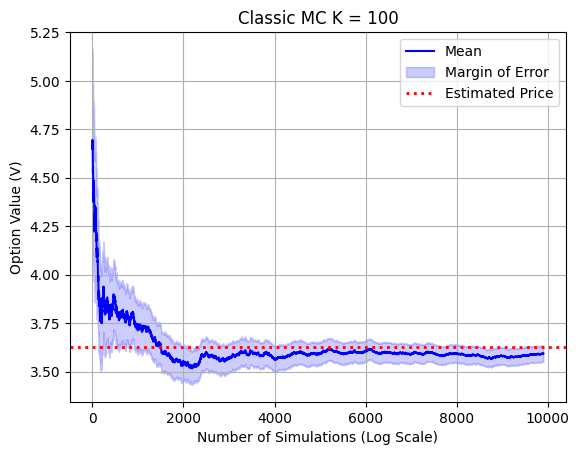

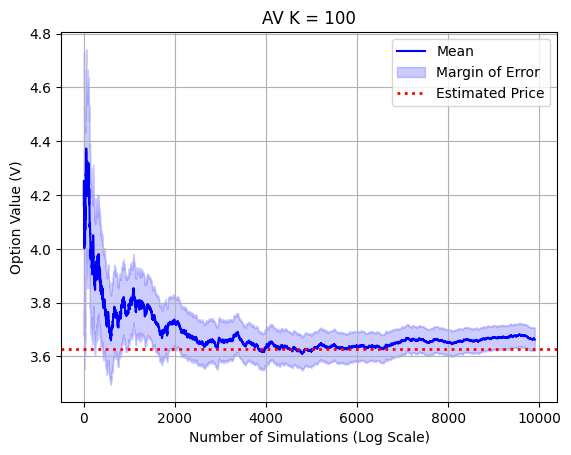

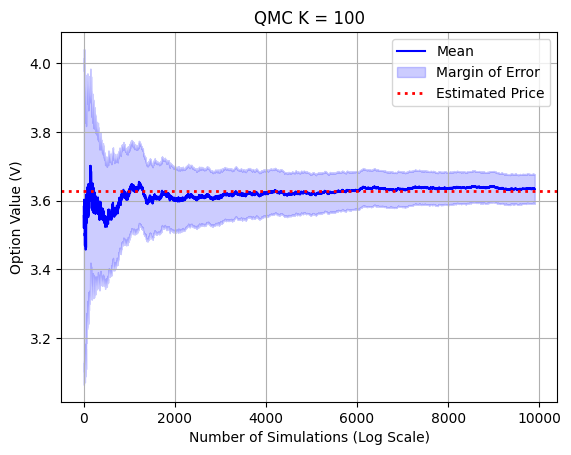

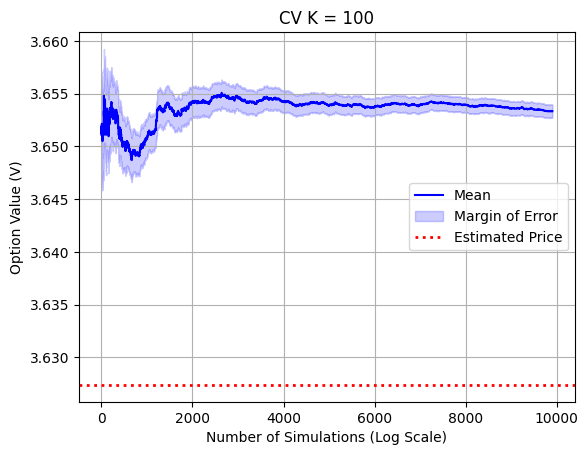

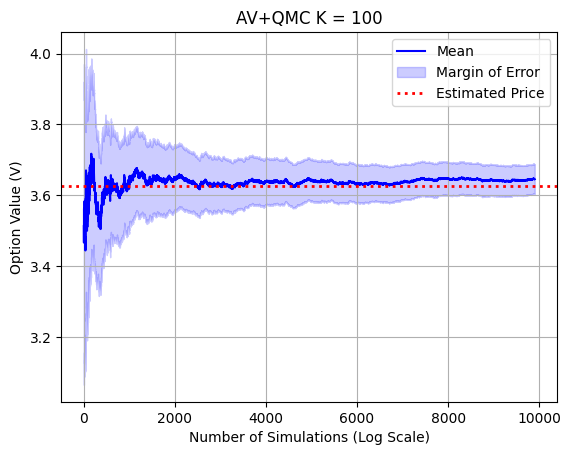

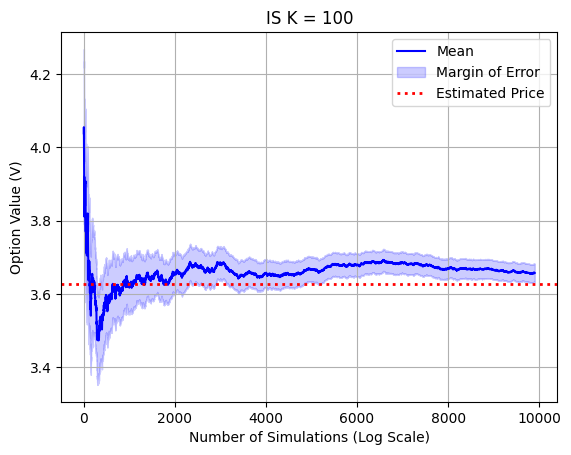

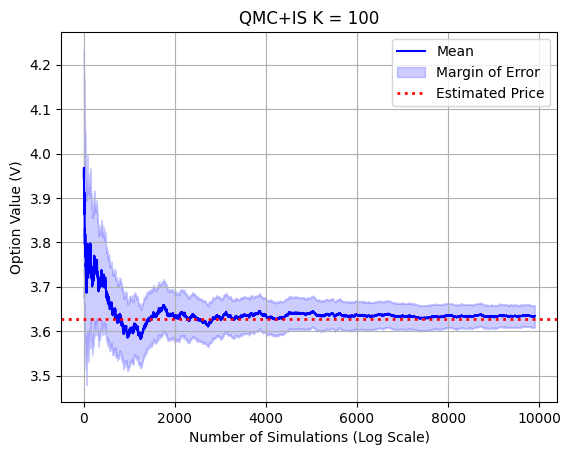

In [346]:
plot_results(base_method, title = "Classic MC K = 100", start = 100, true_v = true100)
for key in reduction_methods.keys():
    plot_results(reduction_methods[key], title=key + " K = 100", start = 100, true_v = true100)

### Plots K = 120

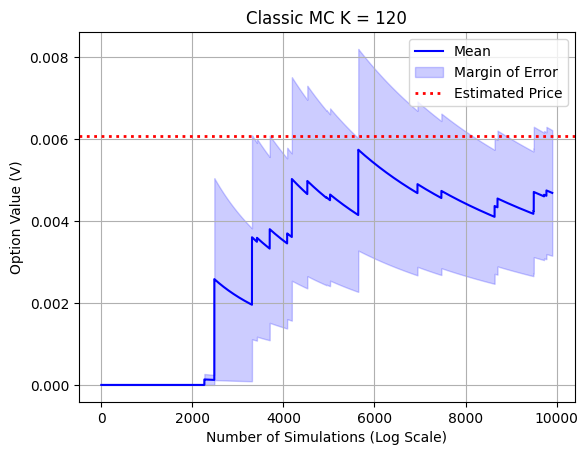

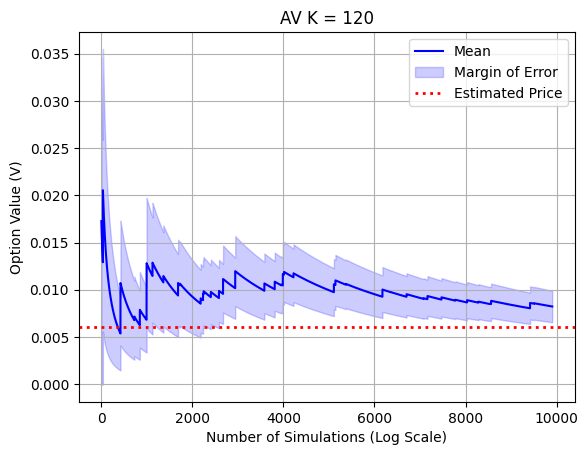

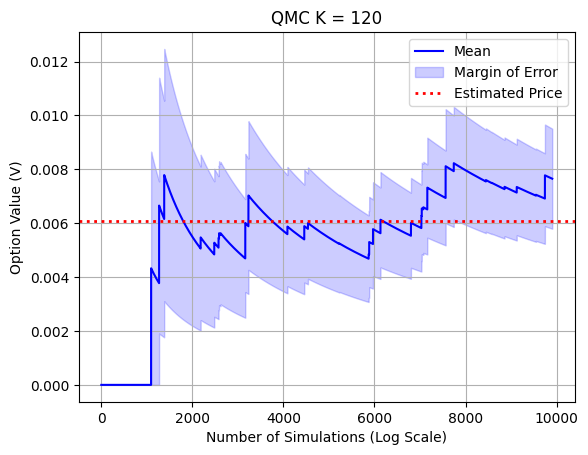

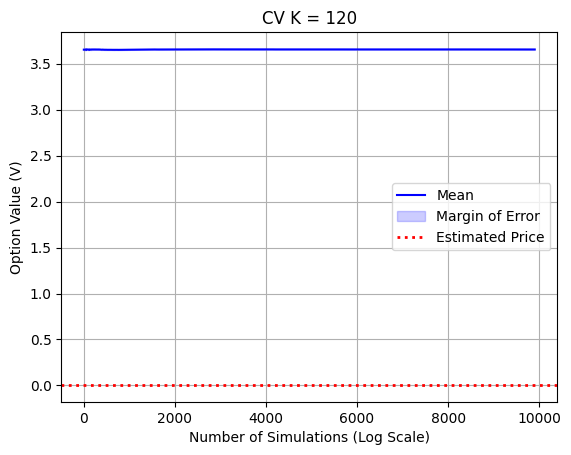

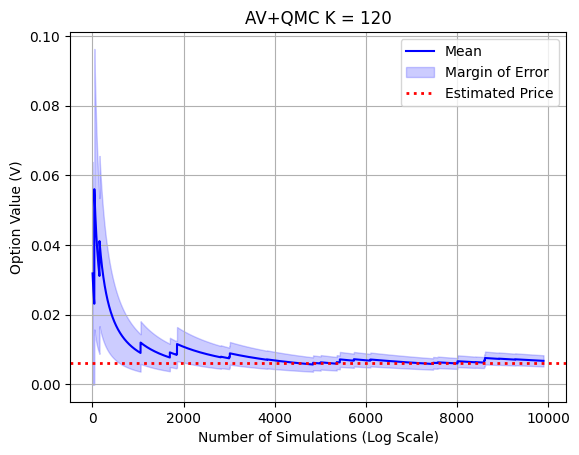

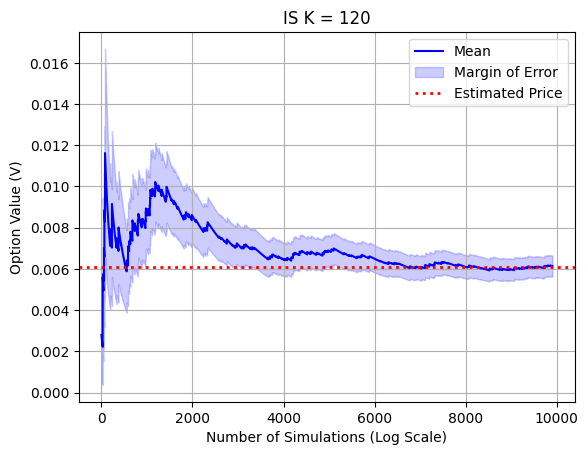

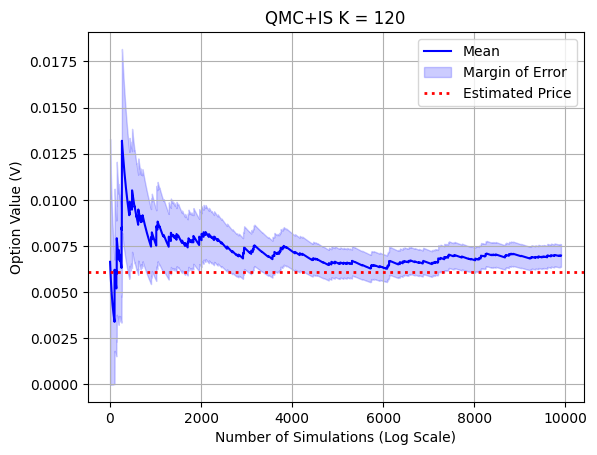

In [345]:
plot_results(base_method_110, title = "Classic MC K = 120", start = 100, true_v = true120)
for key in reduction_methods_110.keys():
    plot_results(reduction_methods_110[key], title=key + " K = 120", start = 100, true_v = true120)

### Plots K = 80

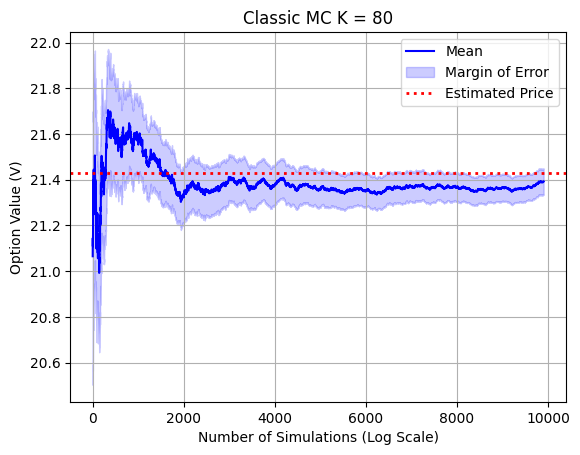

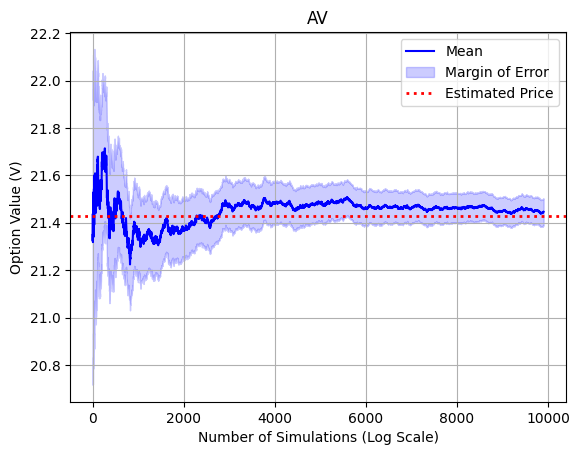

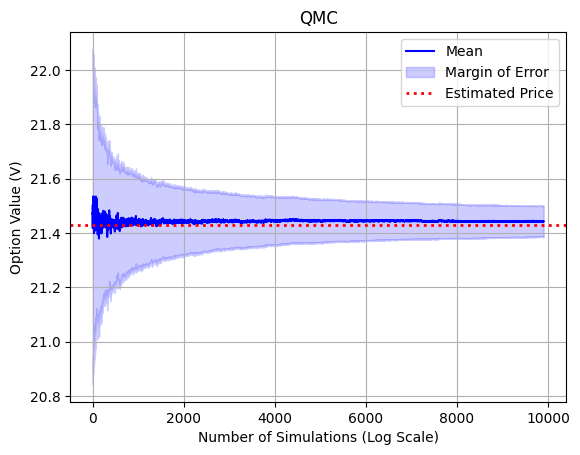

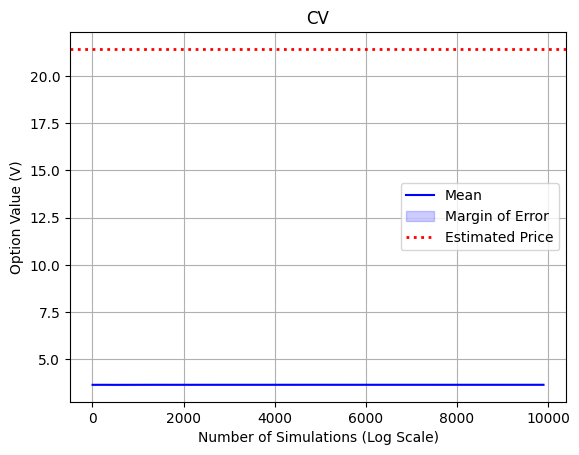

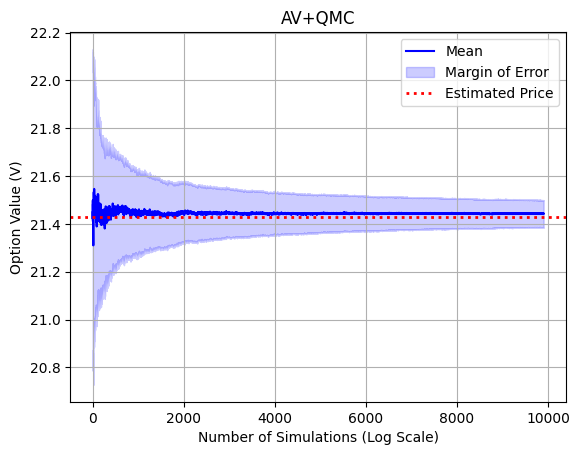

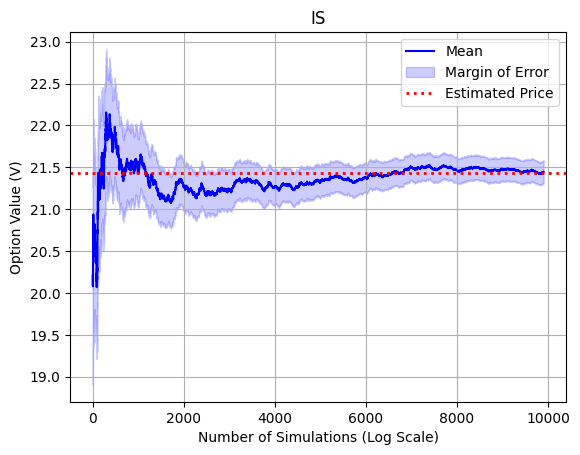

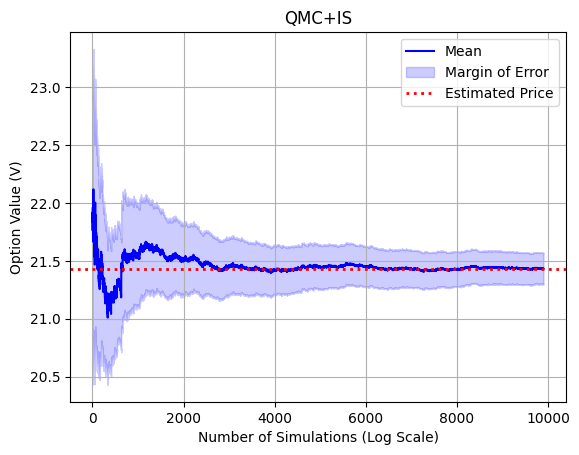

In [344]:
plot_results(base_method_80, title = "Classic MC K = 80", start = 100, true_v = true80)
for key in reduction_methods_80.keys():
    plot_results(reduction_methods_80[key], title=key, start = 100, true_v = true80)

### Variance Reduction Ratio

In [278]:
K100_VRR = np.zeros(len(reduction_methods.keys()))
K110_VRR = np.zeros(len(reduction_methods.keys()))
K080_VRR = np.zeros(len(reduction_methods.keys()))

count = 0
for key in reduction_methods.keys():
    VRR = reduction_methods[key][1][-5:-1] / base_method[1][-5:-1]
    K100_VRR[count] = VRR.mean()
    count = count + 1
    
count = 0
for key in reduction_methods_110.keys():
    VRR = reduction_methods_110[key][1][-5:-1] / base_method_110[1][-5:-1]
    K110_VRR[count] = VRR.mean()
    count = count + 1
    
count = 0
for key in reduction_methods_80.keys():
    VRR = reduction_methods_80[key][1][-5:-1] / base_method_80[1][-5:-1]
    K080_VRR[count] = VRR.mean()
    count = count + 1
    

In [411]:
VRR_df = pd.DataFrame([K080_VRR, K100_VRR, K110_VRR])
VRR_df.columns = reduction_methods.keys()
VRR_df.index = ["K = 80", "K = 100", "K = 120"]
style_helper(VRR_df, "Variance Reduction Ratio")

,AV,QMC,CV,AV+QMC,IS,QMC+IS
K = 80,0.704765,1.001490,0.011108,0.708320,2.391605,2.383290
K = 100,0.712711,1.016597,0.015112,0.713968,0.593275,0.587852
K = 120,0.851091,1.210884,0.409762,0.739038,0.333169,0.400012


### Multisamples, QMC Outperformance

In [309]:
multi_mc = multisample(10, 10000)

In [310]:
multi_qmc = multisample(10, 10000, sample_method = quasi_Sobol)

C:\Users\starr\AppData\Local\Temp\ipykernel_30572\2317470957.py:3: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(n)


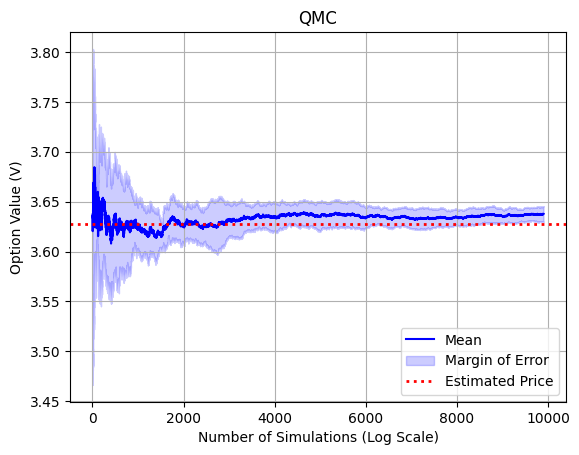

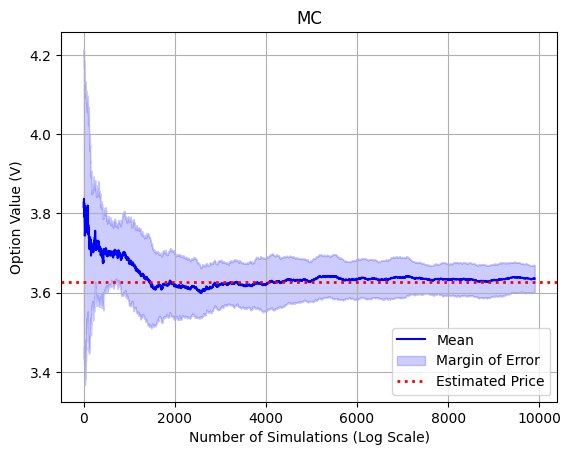

In [340]:
plot_results(multi_qmc, title = "QMC", start = 100, true_v = true100)
plot_results(multi_mc, title = "MC", start = 100, true_v = true100)

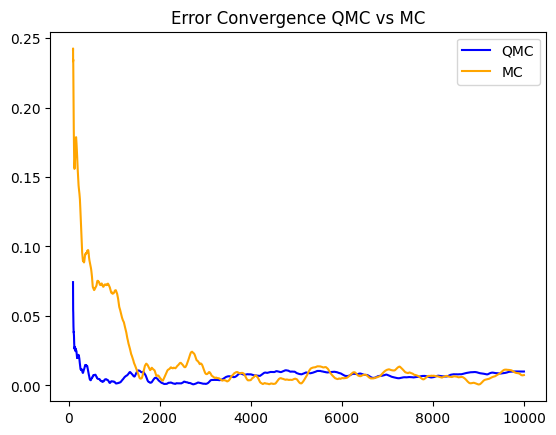

In [339]:
errs = np.abs(multi_qmc[0] - true100)
errs = pd.Series(errs).rolling(100).mean()
mp.plot(errs, color = "blue", label = "QMC")

errs = np.abs(multi_mc[0] - true100)
errs = pd.Series(errs).rolling(100).mean()
mp.plot(errs, color = "orange", label = "MC")
mp.title("Error Convergence QMC vs MC")
mp.legend()

In [329]:
multi_importance = multisample(10, 10000, mu_shift = 0.05)
multi_importance_qmc = multisample(10, 10000, mu_shift = 0.05, sample_method = quasi_Sobol)

C:\Users\starr\AppData\Local\Temp\ipykernel_30572\2142787284.py:3: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(n)


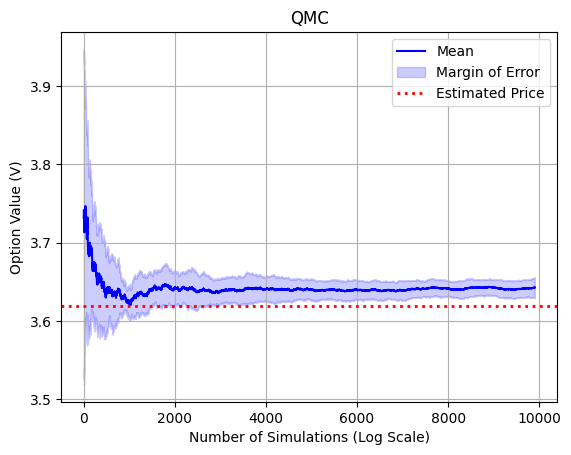

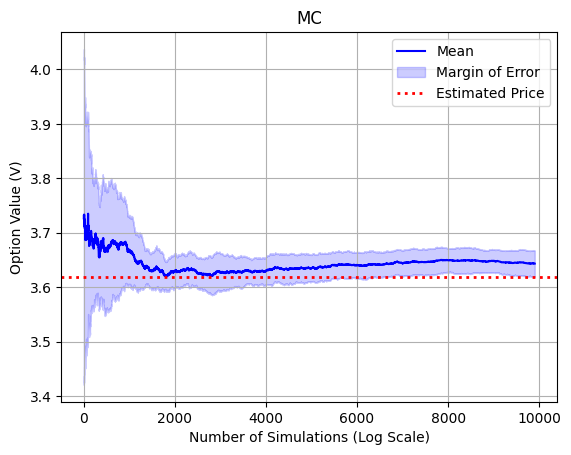

In [347]:
plot_results(multi_importance_qmc, title = "QMC", start = 100)
plot_results(multi_importance, title = "MC", start = 100)

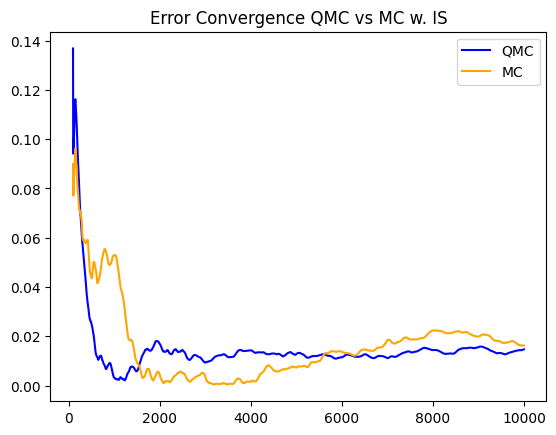

In [338]:
errs = np.abs(multi_importance_qmc[0] - true100)
errs = pd.Series(errs).rolling(100).mean()
mp.plot(errs, color = "blue", label = "QMC")

errs = np.abs(multi_importance[0] - true100)
errs = pd.Series(errs).rolling(100).mean()
mp.plot(errs, color = "orange", label = "MC")
mp.title("Error Convergence QMC vs MC w. IS")
mp.legend()

## Data Tables 

### All Results

### K = 80

In [405]:
display(style_dataframe(base_method_80, title = "Classic MC K = 80"))

for key in reduction_methods_80.keys():
    display(style_dataframe(reduction_methods_80[key], title = key + " K = 80"))

,Option Price (V),MOE
Num Samples,,
10,19.626791,1.719723
100,20.896937,0.542392
1000,21.558538,0.176556
10000,21.392897,0.056589


,Option Price (V),MOE
Num Samples,,
10,18.153519,0.923598
100,21.338501,0.619770
1000,21.385619,0.187165
10000,21.445948,0.056402


,Option Price (V),MOE
Num Samples,,
10,21.402246,1.733231
100,21.435899,0.579180
1000,21.439936,0.178741
10000,21.443094,0.056672


,Option Price (V),MOE
Num Samples,,
10,3.669255,0.022668
100,3.651916,0.005256
1000,3.649955,0.001879
10000,3.653355,0.000629


,Option Price (V),MOE
Num Samples,,
10,21.230274,2.864182
100,21.483825,0.645605
1000,21.451398,0.181536
10000,21.442826,0.056706


,Option Price (V),MOE
Num Samples,,
10,25.451795,5.114233
100,20.203303,1.222062
1000,21.477809,0.428818
10000,21.445879,0.135339


,Option Price (V),MOE
Num Samples,,
10,22.637570,4.793867
100,21.701447,1.329266
1000,21.583050,0.464326
10000,21.431904,0.134870


### K = 100

In [407]:
display(style_dataframe(base_method, title = "Classic MC K = 100"))

for key in reduction_methods.keys():
    display(style_dataframe(reduction_methods[key], title = key + " K = 100"))

,Option Price (V),MOE
Num Samples,,
10,3.263680,1.366912
100,4.685905,0.476525
1000,3.789853,0.133572
10000,3.592616,0.041593


,Option Price (V),MOE
Num Samples,,
10,2.242114,1.484980
100,4.202253,0.487073
1000,3.784942,0.137744
10000,3.662319,0.042310


,Option Price (V),MOE
Num Samples,,
10,6.770589,3.074743
100,3.522067,0.462935
1000,3.616547,0.136413
10000,3.634018,0.042286


,Option Price (V),MOE
Num Samples,,
10,3.669255,0.022668
100,3.651916,0.005256
1000,3.649955,0.001879
10000,3.653355,0.000629


,Option Price (V),MOE
Num Samples,,
10,3.718631,1.435104
100,3.511389,0.411992
1000,3.645636,0.133340
10000,3.645968,0.042004


,Option Price (V),MOE
Num Samples,,
10,3.795918,0.641063
100,4.078723,0.213290
1000,3.636095,0.076349
10000,3.657457,0.024678


,Option Price (V),MOE
Num Samples,,
10,4.961098,1.022834
100,3.972258,0.274143
1000,3.602712,0.077634
10000,3.634027,0.024456


### K = 120

In [408]:
display(style_dataframe(base_method_110, title = "Classic MC K = 120"))

for key in reduction_methods_110.keys():
    display(style_dataframe(reduction_methods_110[key], title = key + " K = 120"))

,Option Price (V),MOE
Num Samples,,
10,0.000000,0.000000
100,0.000000,0.000000
1000,0.000000,0.000000
10000,0.004690,0.001534


,Option Price (V),MOE
Num Samples,,
10,0.000000,0.000000
100,0.017431,0.017518
1000,0.007455,0.003796
10000,0.008223,0.001670


,Option Price (V),MOE
Num Samples,,
10,0.000000,0.000000
100,0.000000,0.000000
1000,0.000000,0.000000
10000,0.007652,0.001857


,Option Price (V),MOE
Num Samples,,
10,3.669255,0.022668
100,3.651916,0.005256
1000,3.649955,0.001879
10000,3.653355,0.000629


,Option Price (V),MOE
Num Samples,,
10,0.000000,0.000000
100,0.032176,0.032338
1000,0.010408,0.006189
10000,0.006754,0.001603


,Option Price (V),MOE
Num Samples,,
10,0.000000,0.000000
100,0.002822,0.002354
1000,0.008294,0.001978
10000,0.006136,0.000511


,Option Price (V),MOE
Num Samples,,
10,0.000000,0.000000
100,0.006704,0.006738
1000,0.007467,0.002034
10000,0.006982,0.000614
